In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import chess
import os
from tqdm import tqdm
import logging
from typing import List, Tuple, Dict, Optional

# Thiết lập logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')



In [7]:
# Đọc file CSV
df = pd.read_csv('ai/data/games_wgm.csv')

# Hiển thị 5 dòng đầu tiên để kiểm tra
print(len(df))
print(df.columns)
print(df.head())

304767
Index(['game_id', 'game_url', 'pgn', 'time_control', 'end_time', 'rated',
       'time_class', 'rules', 'wgm_username', 'white_username', 'white_rating',
       'white_result', 'black_username', 'black_rating', 'black_result'],
      dtype='object')
     game_id                                   game_url  \
0  372626070  https://www.chess.com/live/game/372626070   
1  376650570  https://www.chess.com/live/game/376650570   
2  593979727  https://www.chess.com/live/game/593979727   
3  613859708  https://www.chess.com/live/game/613859708   
4  634471928  https://www.chess.com/live/game/634471928   

                                                 pgn time_control  \
0  [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...      4500+30   
1  [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...      3600+30   
2  [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...      4500+30   
3  [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...      3600+30   
4  [Event "Live Chess"]\n[Site "Chess.com"]

In [8]:
df[['pgn']]

,pgn
0,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
1,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
2,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
3,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
4,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
...,...
304762,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
304763,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
304764,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
304765,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."



Thông tin bảng dữ liệu sau xử lý và lọc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304767 entries, 0 to 304766
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   game_id         304767 non-null  object
 1   game_url        304767 non-null  object
 2   pgn             301294 non-null  object
 3   time_control    304767 non-null  object
 4   end_time        304767 non-null  object
 5   rated           304767 non-null  bool  
 6   time_class      304767 non-null  object
 7   rules           304767 non-null  object
 8   wgm_username    304767 non-null  object
 9   white_username  304767 non-null  object
 10  white_rating    304767 non-null  int64 
 11  white_result    304767 non-null  object
 12  black_username  304767 non-null  object
 13  black_rating    304767 non-null  int64 
 14  black_result    304767 non-null  object
 15  EloDifference   304767 non-null  int64 
dtypes: bool(1), int64(3), object(12)

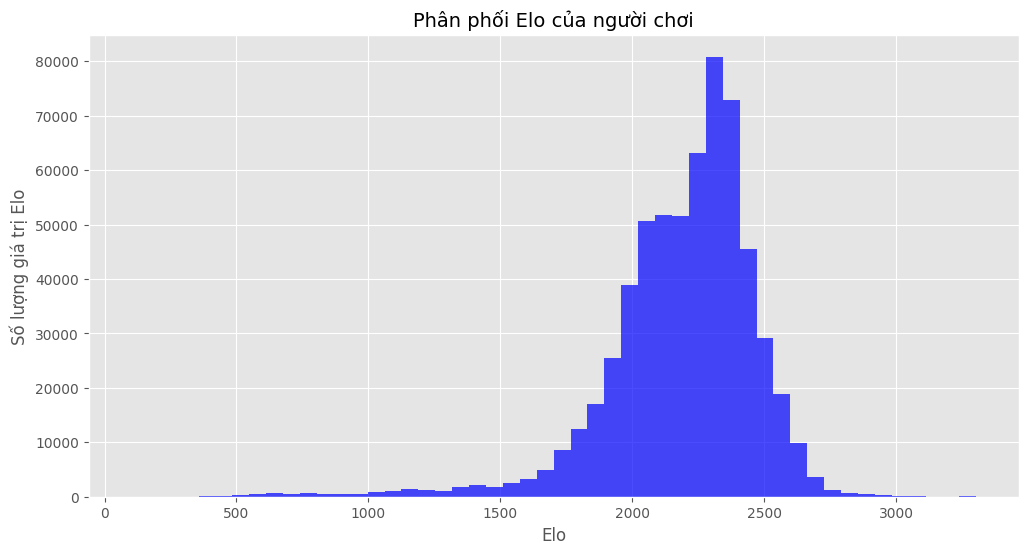

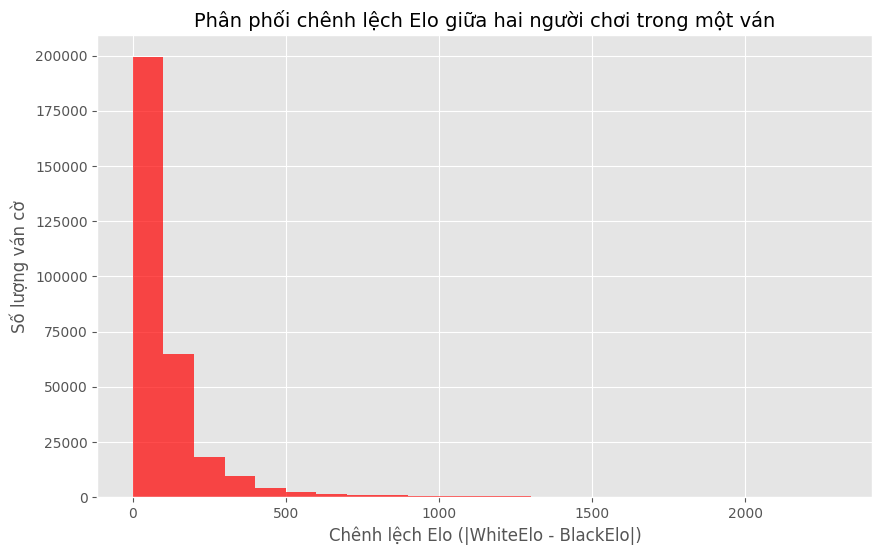


Thống kê cơ bản (sau khi lọc Elo > 2000):
Trung bình tất cả Elo: 2190.43
Trung bình chênh lệch Elo: 113.77
Độ lệch chuẩn tất cả Elo: 281.54
Độ lệch chuẩn chênh lệch Elo: 172.53


In [9]:

df_pgn = df.copy()
# Chuyển đổi Elo thành số
df_pgn['white_rating'] = pd.to_numeric(df_pgn['white_rating'], errors='coerce')
df_pgn['black_rating'] = pd.to_numeric(df_pgn['black_rating'], errors='coerce')

# Loại bỏ các dòng có giá trị NaN trong white_rating hoặc black_rating
df_pgn = df_pgn.dropna(subset=['white_rating', 'black_rating'])

# Chuyển đổi Elo thành số nguyên
df_pgn['white_rating'] = df_pgn['white_rating'].astype(int)
df_pgn['black_rating'] = df_pgn['black_rating'].astype(int)

# Tính chênh lệch Elo tuyệt đối
df_pgn['EloDifference'] = abs(df_pgn['white_rating'] - df_pgn['black_rating'])

# Kết hợp tất cả Elo (white_rating và black_rating)
all_elo = pd.concat([df_pgn['white_rating'], df_pgn['black_rating']]).reset_index(drop=True)

# Kiểm tra dữ liệu sau xử lý
print("\nThông tin bảng dữ liệu sau xử lý và lọc:")
print(df_pgn.info())
print("\n5 hàng đầu tiên của bảng sau xử lý:")
print(df_pgn.head())

# Thiết lập kiểu hiển thị cho biểu đồ
plt.style.use('ggplot')

# 1. Histogram cho tất cả Elo (white_rating và black_rating kết hợp)
plt.figure(figsize=(12, 6))
max_diff = all_elo.max()
bins = range(0, int(max_diff) + 100, 100)  # Tạo bins với bước 100
plt.hist(all_elo, bins=50, color='blue', alpha=0.7)
plt.title('Phân phối Elo của người chơi', fontsize=14)
plt.xlabel('Elo', fontsize=12)
plt.ylabel('Số lượng giá trị Elo', fontsize=12)
plt.grid(True)
plt.show()

# 2. Histogram cho chênh lệch Elo (bin width = 100)
max_diff = df_pgn['EloDifference'].max()
bins = range(0, int(max_diff) + 100, 100)  # Tạo bins với bước 100
plt.figure(figsize=(10, 6))
plt.hist(df_pgn['EloDifference'], bins=bins, color='red', alpha=0.7)
plt.title('Phân phối chênh lệch Elo giữa hai người chơi trong một ván', fontsize=14)
plt.xlabel('Chênh lệch Elo (|WhiteElo - BlackElo|)', fontsize=12)
plt.ylabel('Số lượng ván cờ', fontsize=12)
plt.grid(True)
plt.show()

# Thống kê cơ bản
print("\nThống kê cơ bản (sau khi lọc Elo > 2000):")
print("Trung bình tất cả Elo:", round(all_elo.mean(), 2))
print("Trung bình chênh lệch Elo:", round(df_pgn['EloDifference'].mean(), 2))
print("Độ lệch chuẩn tất cả Elo:", round(all_elo.std(), 2))
print("Độ lệch chuẩn chênh lệch Elo:", round(df_pgn['EloDifference'].std(), 2))

In [11]:
import re

# Hàm parse PGN để trích xuất thông tin và nước đi
def parse_pgn(pgn_str):
    info = {}
    if not isinstance(pgn_str, str):
        return {
            "Result": None,
            "WhiteElo": None,
            "BlackElo": None,
            "Moves": None
        }
    
    fields = ['Result', 'WhiteElo', 'BlackElo']
    for field in fields:
        match = re.search(rf'\[{field} \"(.*?)\"\]', pgn_str)
        info[field] = match.group(1) if match else None
    
    # Trích xuất nước đi
    game = chess.pgn.read_game(io.StringIO(pgn_str))
    if game is None:
        info['Moves'] = None
    else:
        moves = ""
        for move in game.mainline_moves():
            moves += str(move) + " "
        info['Moves'] = moves.strip()
    
    return info

# Làm sạch dữ liệu: chỉ giữ các dòng có PGN hợp lệ
df_valid = df[df['pgn'].apply(lambda x: isinstance(x, str))].copy()

# Trích xuất thông tin từ PGN
df_pgn = df_valid['pgn'].apply(parse_pgn)
df_pgn = pd.DataFrame(df_pgn.tolist())




Thông tin bảng dữ liệu sau xử lý và lọc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301294 entries, 0 to 301293
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Result         301294 non-null  object
 1   white_rating   301294 non-null  int64 
 2   black_rating   301294 non-null  int64 
 3   Moves          301294 non-null  object
 4   MoveCount      301294 non-null  int64 
 5   EloDifference  301294 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.8+ MB
None

5 hàng đầu tiên của bảng sau xử lý:
    Result  white_rating  black_rating  \
0      1-0          2577          2262   
1      1-0          2345          2262   
2      1-0          2429          2246   
3  1/2-1/2          2429          2225   
4      1-0          2592          2429   

                                               Moves  MoveCount  EloDifference  
0  e2e4 e7e6 d2d4 d7d5 b1d2 f8e7 g1f3 g8f6 e4e5 f...         65      

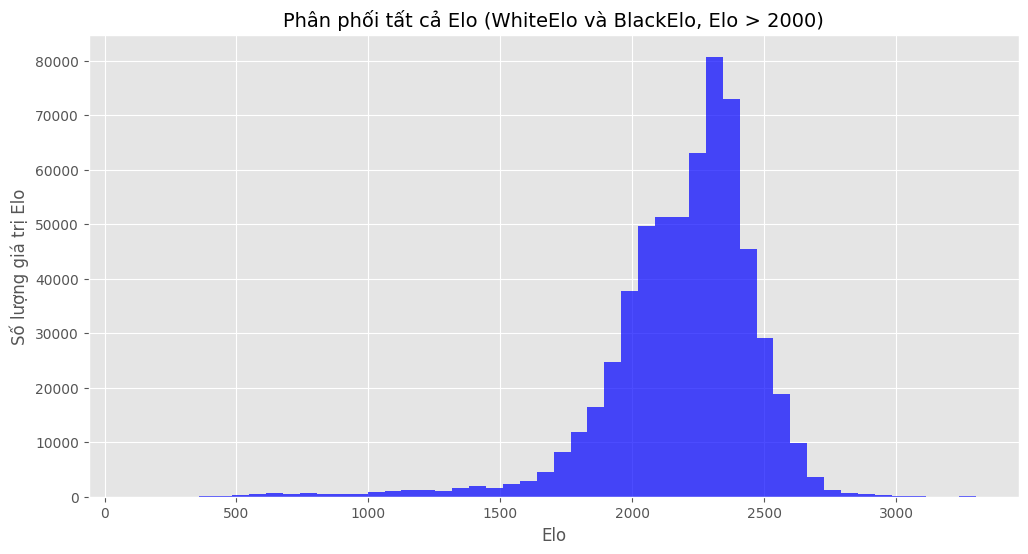

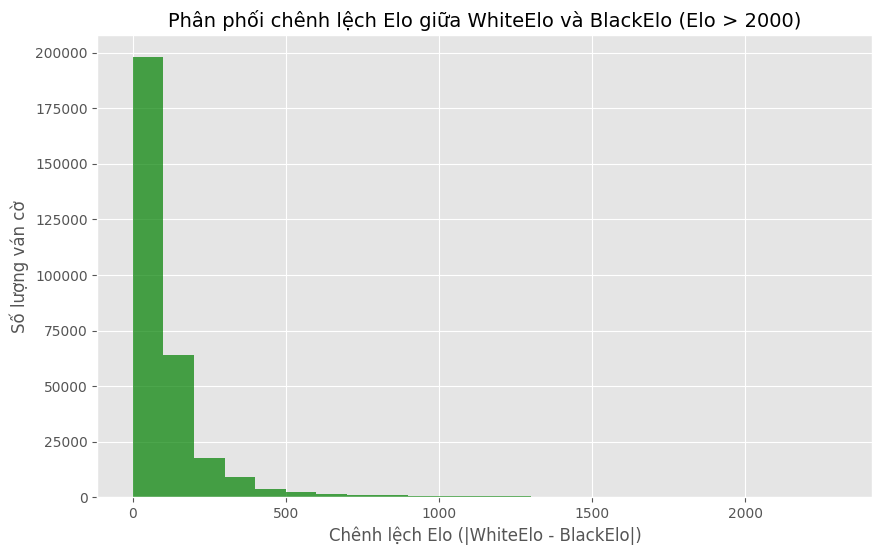

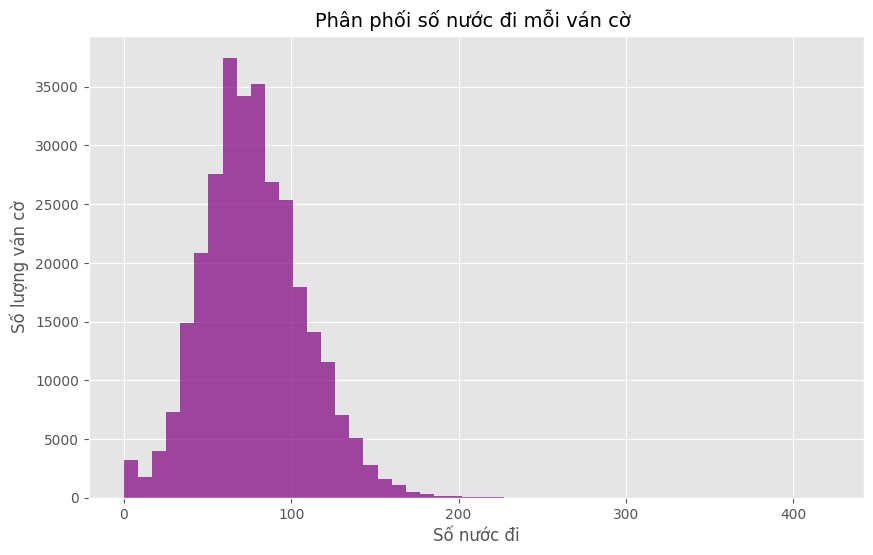


Thống kê cơ bản (sau khi lọc Elo > 2000):
Trung bình tất cả Elo: 2193.75
Trung bình chênh lệch Elo: 112.76
Trung bình số nước đi: 77.84
Độ lệch chuẩn tất cả Elo: 280.01
Độ lệch chuẩn chênh lệch Elo: 172.0
Độ lệch chuẩn số nước đi: 30.31


In [12]:
# Đổi tên cột để đồng bộ (nếu dữ liệu có white_rating/black_rating, bỏ qua bước này)
df_pgn = df_pgn.rename(columns={'WhiteElo': 'white_rating', 'BlackElo': 'black_rating'})

# Tính MoveCount từ chuỗi Moves
df_pgn['MoveCount'] = df_pgn['Moves'].fillna('').apply(lambda x: len(x.strip().split()))

# Chuyển đổi Elo thành số
df_pgn['white_rating'] = pd.to_numeric(df_pgn['white_rating'], errors='coerce')
df_pgn['black_rating'] = pd.to_numeric(df_pgn['black_rating'], errors='coerce')

# Loại bỏ các dòng có giá trị NaN trong white_rating hoặc black_rating
df_pgn = df_pgn.dropna(subset=['white_rating', 'black_rating'])

# Chuyển đổi Elo thành số nguyên
df_pgn['white_rating'] = df_pgn['white_rating'].astype(int)
df_pgn['black_rating'] = df_pgn['black_rating'].astype(int)

# Lọc các ván cờ có Elo > 2000
df_pgn_filtered = df_pgn

# Tính chênh lệch Elo tuyệt đối
df_pgn_filtered['EloDifference'] = abs(df_pgn_filtered['white_rating'] - df_pgn_filtered['black_rating'])

# Kết hợp tất cả Elo (white_rating và black_rating)
all_elo = pd.concat([df_pgn_filtered['white_rating'], df_pgn_filtered['black_rating']]).reset_index(drop=True)

# Kiểm tra dữ liệu sau xử lý
print("\nThông tin bảng dữ liệu sau xử lý và lọc:")
print(df_pgn_filtered.info())
print("\n5 hàng đầu tiên của bảng sau xử lý:")
print(df_pgn_filtered.head())

# Thiết lập kiểu hiển thị cho biểu đồ
plt.style.use('ggplot')

# 1. Histogram cho tất cả Elo (white_rating và black_rating kết hợp)
plt.figure(figsize=(12, 6))
plt.hist(all_elo, bins=50, color='blue', alpha=0.7)
plt.title('Phân phối tất cả Elo (WhiteElo và BlackElo, Elo > 2000)', fontsize=14)
plt.xlabel('Elo', fontsize=12)
plt.ylabel('Số lượng giá trị Elo', fontsize=12)
plt.grid(True)
plt.show()

# 2. Histogram cho chênh lệch Elo (bin width = 100)
max_diff = df_pgn_filtered['EloDifference'].max()
bins = range(0, int(max_diff) + 100, 100)  # Tạo bins với bước 100
plt.figure(figsize=(10, 6))
plt.hist(df_pgn_filtered['EloDifference'], bins=bins, color='green', alpha=0.7)
plt.title('Phân phối chênh lệch Elo giữa WhiteElo và BlackElo (Elo > 2000)', fontsize=14)
plt.xlabel('Chênh lệch Elo (|WhiteElo - BlackElo|)', fontsize=12)
plt.ylabel('Số lượng ván cờ', fontsize=12)
plt.grid(True)
plt.show()

# 3. Histogram cho số nước đi (MoveCount)
plt.figure(figsize=(10, 6))
plt.hist(df_pgn_filtered['MoveCount'], bins=50, color='purple', alpha=0.7)
plt.title('Phân phối số nước đi mỗi ván cờ ', fontsize=14)
plt.xlabel('Số nước đi', fontsize=12)
plt.ylabel('Số lượng ván cờ', fontsize=12)
plt.grid(True)
plt.show()

# Thống kê cơ bản
print("\nThống kê cơ bản (sau khi lọc Elo > 2000):")
print("Trung bình tất cả Elo:", round(all_elo.mean(), 2))
print("Trung bình chênh lệch Elo:", round(df_pgn_filtered['EloDifference'].mean(), 2))
print("Trung bình số nước đi:", round(df_pgn_filtered['MoveCount'].mean(), 2))
print("Độ lệch chuẩn tất cả Elo:", round(all_elo.std(), 2))
print("Độ lệch chuẩn chênh lệch Elo:", round(df_pgn_filtered['EloDifference'].std(), 2))
print("Độ lệch chuẩn số nước đi:", round(df_pgn_filtered['MoveCount'].std(), 2))

In [ ]:
class ChessDataProcessor:
    """
    Class xử lý dữ liệu cờ vua từ file CSV, chuyển thành vector và lưu dưới dạng file .npy.
    """
    
    def __init__(self, history_length: int = 12):
        """
        Khởi tạo bộ xử lý dữ liệu cờ vua.

        Args:
            history_length (int): Số lượng nước đi lịch sử được lưu cho mỗi trạng thái.
        """
        self.history_length = 12  # Đặt lại thành 8 để khớp với mô hình
        self.piece_to_index = {
            'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,  # Quân trắng
            'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11  # Quân đen
        }
        self.material_values = {
            'P': 1, 'p': 1,
            'N': 3, 'n': 3,
            'B': 3, 'b': 3,
            'R': 5, 'r': 5,
            'Q': 9, 'q': 9,
            'K': 0, 'k': 0
        }

    def board_to_matrix(self, board: chess.Board) -> np.ndarray:
        """
        Chuyển trạng thái bàn cờ thành ma trận (8, 8, 12) dạng one-hot.
        """
        piece_map = board.piece_map()
        board_matrix = np.zeros((8, 8, 12), dtype=np.int8)
        
        for square, piece in piece_map.items():
            row, col = divmod(square, 8)
            index = self.piece_to_index.get(piece.symbol())
            if index is not None:
                board_matrix[row][col][index] = 1
        
        return board_matrix

    def uci_to_index(self, uci_move: str) -> Optional[Tuple[int, int]]:
        """
        Chuyển nước đi dạng UCI thành tuple (from_square, to_square).
        """
        try:
            from_square = chess.SQUARE_NAMES.index(uci_move[:2])
            to_square = chess.SQUARE_NAMES.index(uci_move[2:4])
            return (from_square, to_square)
        except Exception as e:
            logging.warning(f"Invalid UCI move: {uci_move}, error: {e}")
            return None

    def calculate_material(self, board: chess.Board) -> int:
        """
        Tính tổng giá trị vật chất trên bàn cờ.
        """
        total_material = 0
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                total_material += self.material_values.get(piece.symbol(), 0)
        return total_material
    
    def process_game_data(self, row: pd.Series, validate_moves: bool = True) -> Tuple[List[Dict], List[Tuple[int, int, int]]]:
        """
        Xử lý một ván cờ thành danh sách (X, y) cho huấn luyện.
        """
        moves = row['Moves'].split()

        if not moves:
            logging.warning(f"Game data has no valid moves: {row}")
            return [], []

        board = chess.Board()
        X, y = [], []
        history = []
        move_count = 0

        for i in range(len(moves) - 1):
            move_uci = moves[i]
            next_move = self.uci_to_index(moves[i+1])

            try:
                if validate_moves:
                    move = chess.Move.from_uci(move_uci)
                    if move not in board.legal_moves:
                        logging.warning(f"Invalid move {move_uci} in game: {row}")
                        break
                side_to_move = 0 if board.turn == chess.WHITE else 1
                castling_rights = [
                    1 if board.has_kingside_castling_rights(chess.WHITE) else 0,
                    1 if board.has_queenside_castling_rights(chess.WHITE) else 0,
                    1 if board.has_kingside_castling_rights(chess.BLACK) else 0,
                    1 if board.has_queenside_castling_rights(chess.BLACK) else 0
                ]
                total_material = self.calculate_material(board)
                game_phase = [0, 0, 0]
                if total_material > 60:
                    game_phase[0] = 1  # Khai cuộc
                elif total_material >= 20:
                    game_phase[1] = 1  # Trung cuộc
                else:
                    game_phase[2] = 1  # Tàn cuộc

                move_info = None
                captured_piece = -1
                special_move_type = 0
                if move:
                    from_square = move.from_square
                    to_square = move.to_square
                    captured = board.piece_at(to_square)
                    captured_piece = self.piece_to_index.get(captured.symbol(), -1) if captured else -1
                    if move_uci in ['e1g1', 'e1c1', 'e8g8', 'e8c8']:
                        special_move_type = 1
                    move_info = (from_square, to_square, captured_piece, special_move_type)

                board.push_uci(move_uci)
                move_count += 1
            except Exception as e:
                # in ra logging.warning(f"Error pushing move {move_uci}: {e}")
                break

            board_matrix = self.board_to_matrix(board)
            history_trimmed = history[-self.history_length:]
            while len(history_trimmed) < self.history_length:
                history_trimmed.insert(0, None)

            is_promotion = 0
            if next_move:
                from_square, to_square = next_move
                piece = board.piece_at(from_square)
                if piece and piece.piece_type == chess.PAWN:
                    to_row = to_square // 8
                    if (piece.color == chess.WHITE and to_row == 7) or (piece.color == chess.BLACK and to_row == 0):
                        is_promotion = 1

            data_point = {
                "board": board_matrix,
                "side_to_move": side_to_move,
                "castling_rights": castling_rights,
                "history": history_trimmed,
                "move_count": move_count,
                "game_phase": game_phase
            }

            if next_move:
                X.append(data_point)
                y.append((next_move[0], next_move[1], is_promotion))

            history.append(move_info)

        return X, y
    
    def process_and_save_csv_data(self, csv_path: str, max_games: Optional[int] = None, 
                                 games_per_file: int = 1000, output_folder: str = "data") -> None:
        """
        Xử lý dữ liệu từ file CSV và lưu dưới dạng các file .npy.

        Args:
            csv_path (str): Đường dẫn đến file CSV.
            max_games (Optional[int]): Số ván cờ tối đa để xử lý (None để đọc toàn bộ).
            games_per_file (int): Số ván cờ mỗi file .npy.
            output_folder (str): Thư mục lưu kết quả.
        """
        print("Reading CSV file...")
        table_pgn = pd.read_csv(csv_path)
        if max_games is not None:
            table_pgn = table_pgn.head(max_games)
        total_games = len(table_pgn)
        print(f"Loaded {total_games} games from CSV")

        os.makedirs(output_folder, exist_ok=True)
        all_X, all_y = [], []
        games_in_file = 0
        file_id = 0
        total_samples = 0

        for idx, row in tqdm(table_pgn.iterrows(), total=total_games, desc="Processing games"):
            X_game, y_game = self.process_game_data(row)
            if X_game and y_game:
                all_X.extend(X_game)
                all_y.extend(y_game)
                total_samples += len(X_game)
                games_in_file += 1
                if idx % 20000 == 0:
                    print(f"Processed {idx+1} games, {total_samples} samples")

            if games_in_file >= games_per_file:
                output_path = os.path.join(output_folder, f"chess_data_{file_id}.npy")
                np.save(output_path, {"X": all_X, "y": all_y}, allow_pickle=True)
                logging.info(f"Saved file: {output_path} with {len(all_X)} samples (games {idx - games_in_file + 1} to {idx})")
                file_id += 1
                all_X, all_y = [], []
                games_in_file = 0

        if all_X and all_y:
            output_path = os.path.join(output_folder, f"chess_data_{file_id}.npy")
            np.save(output_path, {"X": all_X, "y": all_y}, allow_pickle=True)
            logging.info(f"Saved file: {output_path} with {len(all_X)} samples (final)")
        
        print(f"Processed {total_games} games, created {total_samples} samples, saved {file_id + 1} .npy files")

In [25]:
def main():
    processor = ChessDataProcessor(history_length=8)
    processor.process_and_save_csv_data(
        csv_path="ai/data/pgn_chess_data.csv",
        max_games=None,  # Đọc toàn bộ CSV
        games_per_file=20000,
        output_folder="ai/data"
    )

if __name__ == "__main__":
    main()

Reading CSV file...
Loaded 271044 games from CSV


Processing games:   0%|          | 3/271044 [00:00<2:44:16, 27.50it/s]

Processed 1 games, 64 samples


Processing games:   4%|▎         | 9961/271044 [01:38<54:37, 79.66it/s]  2025-05-08 23:21:14,749 - WARNING - Invalid move e1f3 in game: Result                                                            -1
WhiteElo                                                        1963
BlackElo                                                        2433
CurrentPosition          8/kp5p/3Q4/p2p4/5p2/3qbP2/3N3P/1r1KR3 w - -
Moves              e2e4 g7g5 d2d3 d7d6 c2c4 f7f5 e4f5 c8f5 d1c2 e...
MoveCount                                                         56
Name: 9963, dtype: object
2025-05-08 23:21:14,755 - WARNING - Invalid move d1e3 in game: Result                                                            -1
WhiteElo                                                        2139
BlackElo                                                        1978
CurrentPosition                       3K4/r1P5/4k3/8/8/8/6R1/8 w - -
Moves              b2b3 d7d5 g2g4 c7c6 d1e3 e8f6 g4g5 f6e4 h1e4 d...
MoveCount       

KeyboardInterrupt: 